# Dominant Poles

In [70]:
import requests as req, os

URL = "https://raw.githubusercontent.com/mit-acl/16_06_Class/main/"
File = ["basic_material.py","control_materials.py"]

if not os.path.isfile(File[0]):
    print('Basic files not found - downloading them')
    for dfile in File:
        if not os.path.isfile(dfile):
            print("Downloading "+dfile)
            res = req.get(URL+dfile)
            file = open(dfile, 'w')
            file.write(res.text)
            file.close()

print('Basic file found')
%run basic_material.py

from control.matlab import tf,step,tf2ss,ss2tf
import scipy
from control_materials import *


Basic file found
Running Python: 3.12.8
Running Sympy: 1.13.2
Control Package Found


## Example 1 (simple)

In [71]:
s = tf('s')
# slow system
P = 10/(s/1+1)
# Add faster dynamics
P1 = P * 1/(s/2+1)
P2 = P * 1/(s/10+1)

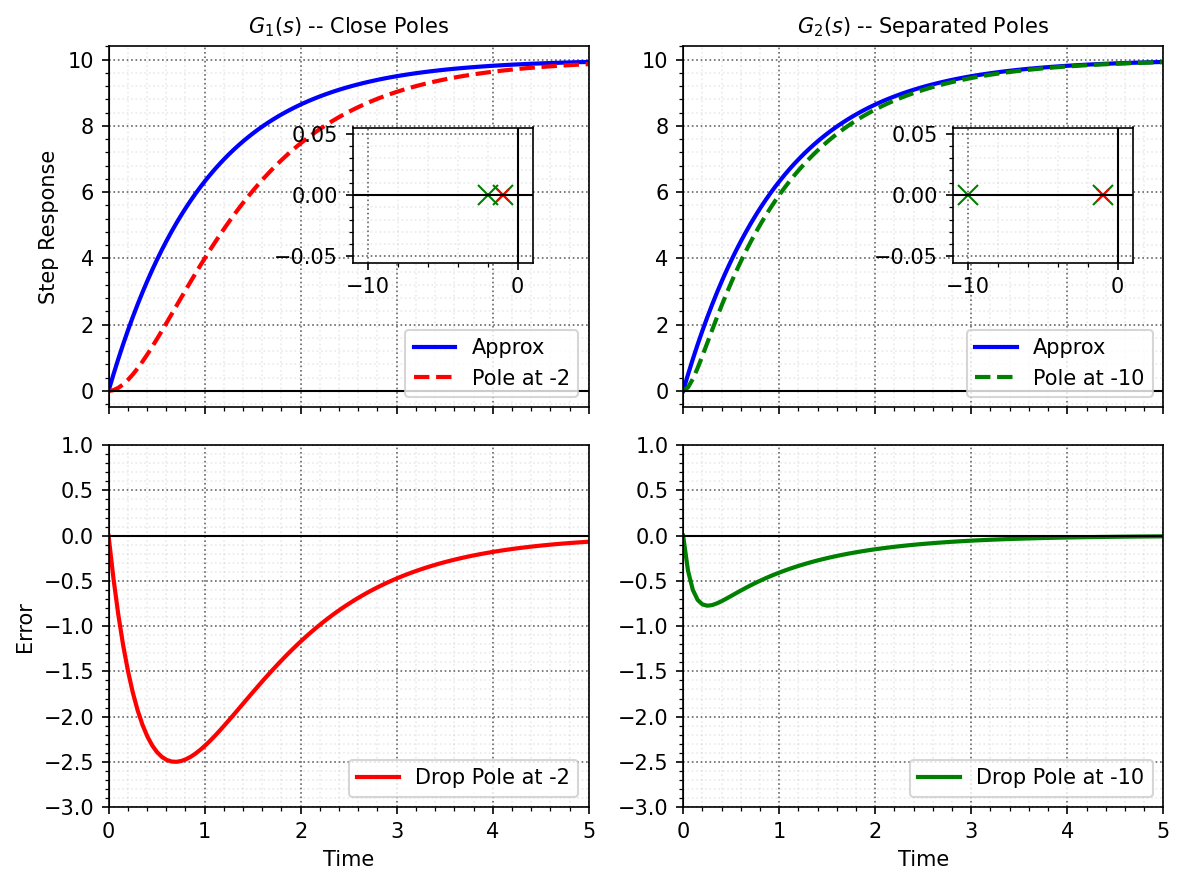

In [72]:
fig, ax = plt.subplots(2,2,figsize=(8, 6),dpi=150,sharex = True)
yap,t = step(P,5)
y1,t = step(P1,t)
y2,t = step(P2,t)

ax[0][0].plot(t,yap,'b',label='Approx')
ax[0][1].plot(t,yap,'b',label='Approx')
ax[0][0].plot(t,y1,'r--',label='Pole at -2')
ax[0][1].plot(t,y2,'g--',label='Pole at -10')
ax[1][0].plot(t,y1-yap,'r-',label='Drop Pole at -2')
ax[1][1].plot(t,y2-yap,'g-',label='Drop Pole at -10')
ax[0][0].set_ylabel("Step Response")
ax[1][0].set_ylabel("Error")
ax[0][0].set_title("$G_1(s)$ -- Close Poles")
ax[0][1].set_title("$G_2(s)$ -- Separated Poles")
ax[1][0].set_ylim(-3,1)
ax[1][1].set_ylim(-3,1)

left, bottom, width, height = [0.3, 0.7, 0.15, 0.15]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.figure.set_facecolor('w')
ax2.plot(np.real(P1.poles()),np.imag(P1.poles()), 'x', ms=10, color='green')
ax2.plot(np.real(P.poles()),np.imag(P.poles()), 'rx', ms=6, color='red')
ax2.set_xlim((-11,1))
#ax2.set_ylim((-1,1))

left, bottom, width, height = [0.8, 0.7, 0.15, 0.15]
ax3 = fig.add_axes([left, bottom, width, height])
ax3.figure.set_facecolor('w')
ax3.plot(np.real(P2.poles()),np.imag(P2.poles()), 'x', ms=10, color='green')
ax3.plot(np.real(P.poles()),np.imag(P.poles()), 'rx', ms=6, color='red')
ax3.set_xlim((-11,1))
#ax3.set_ylim((-1,1))
nicegrid(ax2)
nicegrid(ax3)

#[ax[1][x].set_ylim((-3,.25)) for x in range(2)]
[ax[x][y].legend(loc=4) for x in range(2) for y in range(2)]
[nicegrid(ax[x][y],6)  for x in range(2) for y in range(2)]
[ax[1][x].set_xlabel("Time") for x in range(2)]
savefig("./figs/DP_Ex1.pdf", dpi=600)
plt.show()

In [73]:
from sympy import symbols, inverse_laplace_transform, integrate, oo, simplify

# Define the Laplace variable and the transfer function with complex poles
s = symbols('s')
p, q, t, z = symbols('p q t z', positive=True)
omega = symbols('omega', positive=True)
PP = {}
PP['real'] =  1/ (s + p)
PP['dreal'] = 1 / (s + p)**2
PP['treal'] = 1 / (s + p)/(s + q)
PP['zreal'] = (s + z) / (s + p)/(s + q)
PP['CC'] = 1 / ((s + p)**2 + omega**2)
PP['zCC'] = (s+z) / ((s + p)**2 + omega**2)

for P in PP.values():
    print(P)
    # Compute the inverse Laplace transform (impulse response)
    impulse_response = inverse_laplace_transform(P, s, t)

    # Integrate the impulse response from 0 to infinity
    #integrated_response = simplify(integrate(impulse_response, (t, 0, oo)))
    integrated_square_response = simplify(integrate(impulse_response**2, (t, 0, oo)))

    print(f"Impulse response: {impulse_response}")
    #print(f"Integrated response from 0 to infinity: {integrated_response}")
    print(f"Integrated square response from 0 to infinity: {integrated_square_response}")
    print('\n')

1/(p + s)
Impulse response: exp(-p*t)
Integrated square response from 0 to infinity: 1/(2*p)


(p + s)**(-2)
Impulse response: t*exp(-p*t)
Integrated square response from 0 to infinity: 1/(4*p**3)


1/((p + s)*(q + s))
Impulse response: exp(-t*(p*q - q**2)/(p - q))/(p - q) - exp(-t*(p**2 - p*q)/(p - q))/(p - q)
Integrated square response from 0 to infinity: 1/(2*p*q*(p + q))


(s + z)/((p + s)*(q + s))
Impulse response: (p - z)*exp(-t*(p**2 - p*q)/(p - q))/(p - q) + (-q + z)*exp(-t*(p*q - q**2)/(p - q))/(p - q)
Integrated square response from 0 to infinity: (p*q + z**2)/(2*p*q*(p + q))


1/(omega**2 + (p + s)**2)
Impulse response: exp(-p*t)*sin(omega*t)/omega
Integrated square response from 0 to infinity: 1/(4*p*(omega**2 + p**2))


(s + z)/(omega**2 + (p + s)**2)
Impulse response: exp(-p*t)*cos(omega*t) + (-p + z)*exp(-p*t)*sin(omega*t)/omega
Integrated square response from 0 to infinity: (omega**2 + p**2 + z**2)/(4*p*(omega**2 + p**2))




In [74]:
from sympy import apart, N
S = Symbol('S')

def tf2sympy(P, S=Symbol('S')):
    P_sympy_n = P_sympy_d = 0
    for kk, vv in enumerate(P.num[0][0][::-1]):
        P_sympy_n += vv * S**kk
    for kk, vv in enumerate(P.den[0][0][::-1]):
        P_sympy_d += vv * S**kk
    return P_sympy_n/P_sympy_d

# Show partial fraction expansion
def pfe_print(P, DCmatch = False, printout=False):   
    P_sympy = tf2sympy(P)
    P_sympy_pfe = apart(P_sympy)
    P_red = balred(P)
    if DCmatch:
        P_red *= P.dcgain()/P_red.dcgain()
    P_sympy_red = tf2sympy(P_red)
    P_sympy_red_pfe = apart(P_sympy_red)
    if printout:
        print("P")
        display(N(P_sympy,4))
        print("P PFE")
        display(N(P_sympy_pfe,4))
        print("P Balred")
        display(N(P_sympy_red_pfe,4))
        print("P Control Balred")
        ns = len(P.den[0][0])
        print(ss2tf(balred(tf2ss(P),ns - 2)))
    return P_sympy_red, P_red

Ps1_red, P1_red = pfe_print(P1, printout=True)
Ps2_red, P2_red = pfe_print(P2, printout=True)

P


20.0/(S**2 + 3.0*S + 2.0)

P PFE


-20.0/(S + 2.0) + 20.0/(S + 1.0)

P Balred


4.851/(1.0*S + 0.4086)

P Control Balred
<TransferFunction>: sys[929]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


  4.851
----------
s + 0.4086

P


100.0/(S**2 + 11.0*S + 10.0)

P PFE


-11.11/(S + 10.0) + 11.11/(S + 1.0)

P Balred


7.881/(1.0*S + 0.7319)

P Control Balred
<TransferFunction>: sys[949]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


  7.881
----------
s + 0.7319



## Example 2 (more complex)

In [75]:
s = tf('s')
# slow system
P = 1/(s+1)
# add faster system
P1 = 10**2/(s**2+2*s + 10**2) * P
P2 = P*1/(s/10+1)*1/(s/11+1)

In [76]:
Ps1_red, P1_red = pfe_print(P1, printout=True)
Ps2_red, P2_red = pfe_print(P2, printout=True)

P


100.0/(S**3 + 3.0*S**2 + 102.0*S + 100.0)

P PFE


-1.01*(S + 1.0)/(S**2 + 2.0*S + 100.0) + 1.01/(S + 1.0)

P Balred


-0.5674*(0.01919*S - 1.0)/(0.08531*S**2 + 0.2308*S + 1.0)

P Control Balred
<TransferFunction>: sys[998]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


  -0.1276 s + 6.651
---------------------
s^2 + 2.705 s + 11.72

P


110.0/(S**3 + 22.0*S**2 + 131.0*S + 110.0)

P PFE


11.0/(S + 11.0) - 12.22/(S + 10.0) + 1.222/(S + 1.0)

P Balred


-0.8763*(0.0277*S - 1.0)/(0.1601*S**2 + 1.0*S + 0.8848)

P Control Balred
<TransferFunction>: sys[1018]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


  -0.1517 s + 5.475
---------------------
s^2 + 6.248 s + 5.528



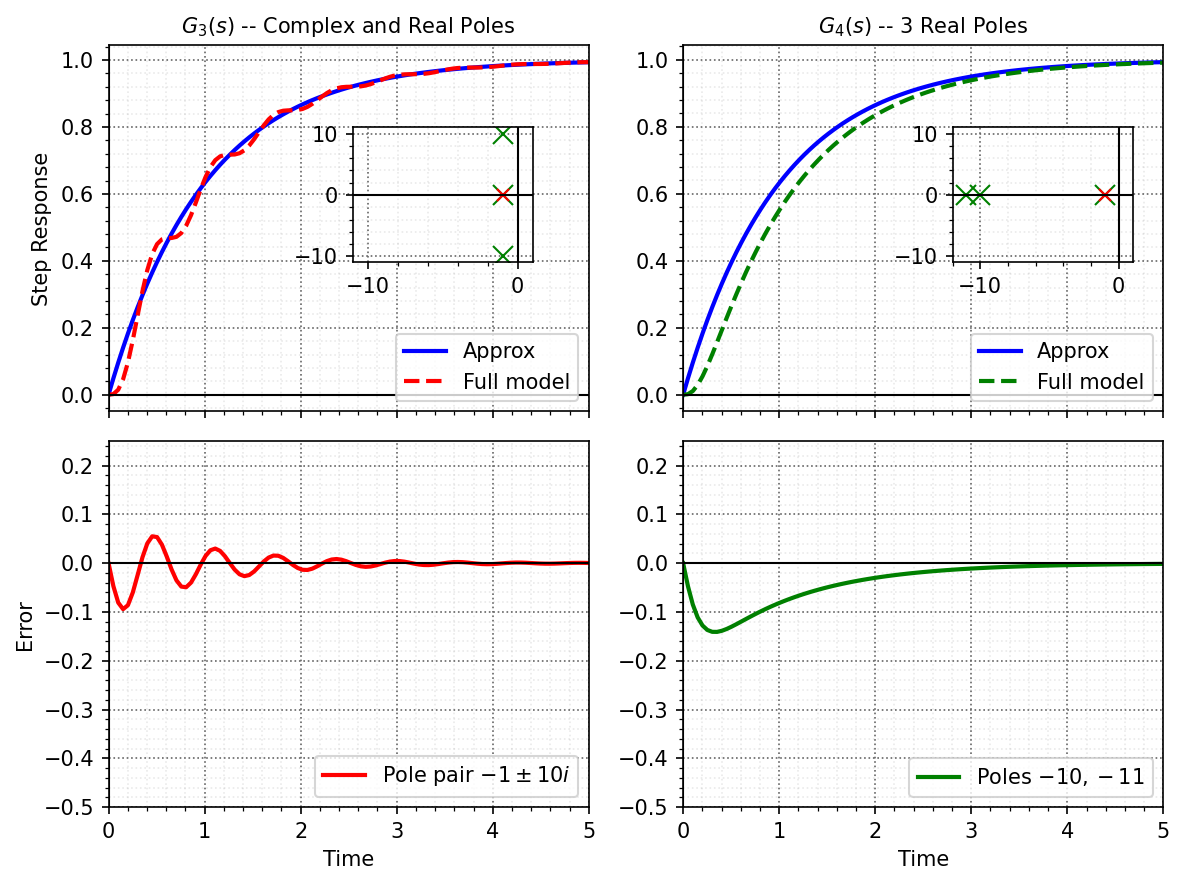

In [77]:
fig, ax = plt.subplots(2,2,figsize=(8, 6),dpi=150,sharex = True)
yap,t = step(P,5)
y1,t = step(P1,t)
y2,t = step(P2,t)

ax[0][0].plot(t,yap,'b',label='Approx')
ax[0][1].plot(t,yap,'b',label='Approx')
ax[0][0].plot(t,y1,'r--',label=r'Full model')
ax[0][1].plot(t,y2,'g--',label='Full model')
ax[1][0].plot(t,y1-yap,'r-',label=r'Pole pair $-1\pm 10i$')
ax[1][1].plot(t,y2-yap,'g-',label=r'Poles $-10,-11$')
ax[0][0].set_ylabel("Step Response")
ax[1][0].set_ylabel("Error")
ax[0][0].set_title("$G_3(s)$ -- Complex and Real Poles")
ax[0][1].set_title("$G_4(s)$ -- 3 Real Poles")

left, bottom, width, height = [0.3, 0.7, 0.15, 0.15]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.figure.set_facecolor('w')
ax2.plot(np.real(P1.poles()),np.imag(P1.poles()), 'x', ms=10, color='green')
ax2.plot(np.real(P.poles()),np.imag(P.poles()), 'rx', ms=6, color='red')
ax2.set_xlim((-11,1))
ax2.set_ylim((-11,11))

left, bottom, width, height = [0.8, 0.7, 0.15, 0.15]
ax3 = fig.add_axes([left, bottom, width, height])
ax3.figure.set_facecolor('w')
ax3.plot(np.real(P2.poles()),np.imag(P2.poles()), 'x', ms=10, color='green')
ax3.plot(np.real(P.poles()),np.imag(P.poles()), 'rx', ms=6, color='red')
ax3.set_xlim((-12,1))
ax3.set_ylim((-11,11))
nicegrid(ax2)
nicegrid(ax3)

[ax[1][x].set_ylim((-.5,.25)) for x in range(2)]
[ax[x][y].legend(loc=4) for x in range(2) for y in range(2)]
[nicegrid(ax[x][y],6)  for x in range(2) for y in range(2)]
[ax[1][x].set_xlabel("Time") for x in range(2)]
savefig("./figs/DP_Ex2.pdf", dpi=600)
plt.show()

In [78]:
from scipy.signal import residue

def print_pfe_info(P):
    r, p, k = residue(P.num[0][0], P.den[0][0])
    pretty_row_print(r,"Residues:")
    pretty_row_print(p,"Poles:")
    pretty_row_print(k,"Direct term:")
    return r, p, k

print_pfe_info(P1)
print("")
print_pfe_info(P2)    


Residues:1.010, (-0.51 + 0.00i), (-0.51 + -0.00i)
Poles:-1.000, (-1.00 + 9.95i), (-1.00 + -9.95i)
Direct term:

Residues:1.222, -12.222, 11.000
Poles:-1.000, -10.000, -11.000
Direct term:


(array([   1.222,  -12.222,   11.000]),
 array([  -1.000,  -10.000,  -11.000]),
 array([], dtype=float64))

## Example 3 (with Zeros)

In [79]:
s = tf('s')
# slow
P = 1/(s+1)
# add faster with a zero
P1 = (s/1.1+1)/(s/10+1) * P
P2 = (s/2.1+1)/(s/2+1) * P

yap,t = step(P,5)
y1,t = step(P1,t)
y2,t = step(P2,t)

In [80]:
Ps1_red, P1_red = pfe_print(P1, printout=True)
Ps2_red, P2_red = pfe_print(P2, printout=True)
balred(P2,1)

P


(10.0*S + 11.0)/(1.1*S**2 + 12.1*S + 11.0)

P PFE


0.101/(S + 1.0) + 0.899/(0.1*S + 1.0)

P Balred


0.935/(0.1039*S + 1.0)

P Control Balred
<TransferFunction>: sys[1070]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


  9.002
---------
s + 9.628

P


(2.0*S + 4.2)/(2.1*S**2 + 6.3*S + 4.2)

P PFE


1.048/(S + 1.0) - 0.04762/(0.5*S + 1.0)

P Balred


0.9636/(1.0*S + 0.9584)

P Control Balred
<TransferFunction>: sys[1090]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


  0.9636
----------
s + 0.9584



TransferFunction(array([   0.964]), array([   1.000,    0.958]))

In [81]:
from sympy import latex
ss = Symbol('s')
sP = 1/(ss+1)
sP1 = (ss/1.1+1)/(ss/10+1) * sP
sP2 = (ss/2.1+1)/(ss/2+1) * sP
print(sP1.apart())
print(latex(sP1.apart()))

0.101010101010101/(s + 1) + 0.898989898989899/(0.1*s + 1.0)
\frac{0.101010101010101}{s + 1} + \frac{0.898989898989899}{0.1 s + 1.0}


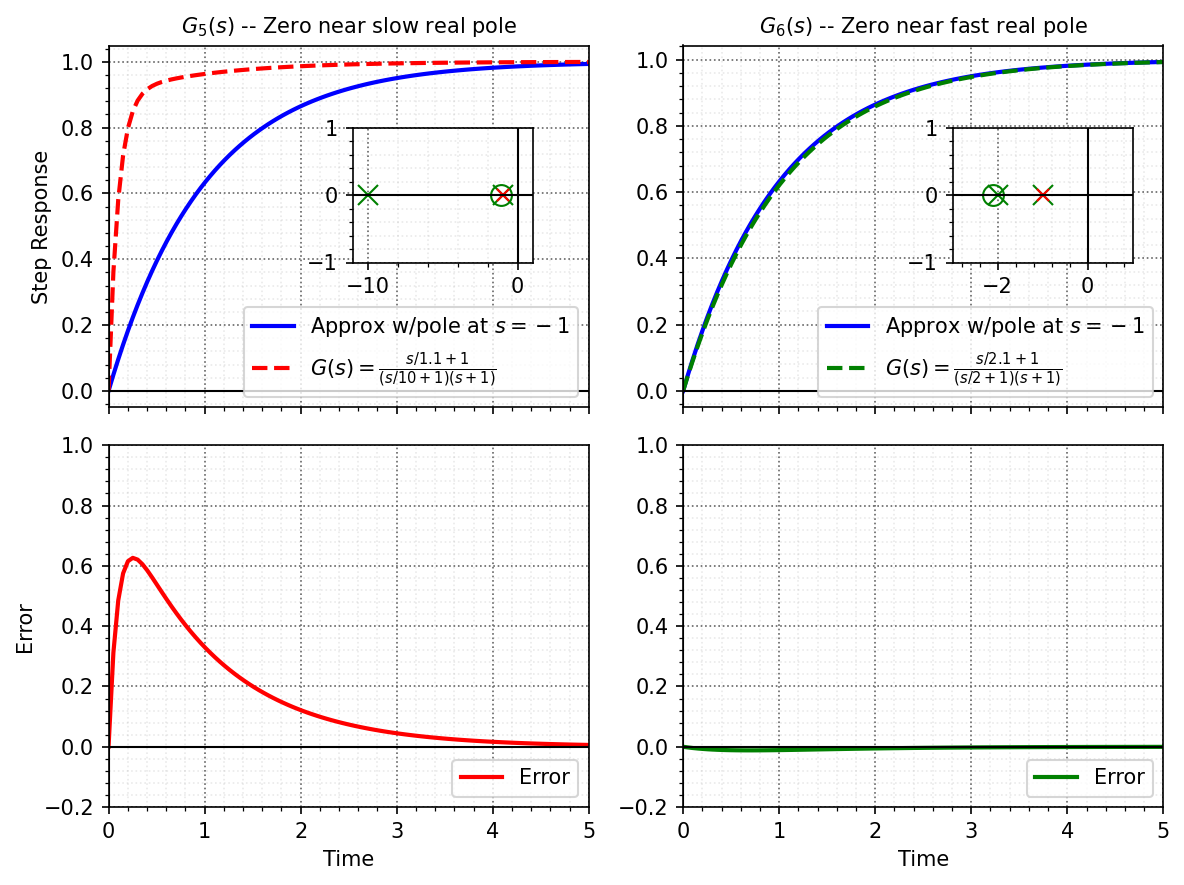

In [82]:
fig, ax = plt.subplots(2,2,figsize=(8, 6),dpi=150,sharex = True)

[ax[0][x].plot(t,yap,'b',label=r'Approx w/pole at $s=-1$') for x in range(2)]
ax[0][0].plot(t,y1,'r--',label=r'$G(s) = \frac{s/1.1+1}{(s/10+1)(s+1)}$')
ax[0][1].plot(t,y2,'g--',label=r'$G(s) = \frac{s/2.1+1}{(s/2+1)(s+1)}$')
ax[1][0].plot(t,y1-yap,'r-',label=r'Error')
ax[1][1].plot(t,y2-yap,'g-',label=r'Error')
ax[0][0].set_ylabel("Step Response")
ax[1][0].set_ylabel("Error")

left, bottom, width, height = [0.3, 0.7, 0.15, 0.15]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.figure.set_facecolor('w')
ax2.plot(np.real(P1.poles()),np.imag(P1.poles()), 'x', ms=10, color='green')
ax2.plot(np.real(P1.zeros()),np.imag(P1.zeros()), 'o', markerfacecolor='none', ms=10, color='green')
ax2.plot(np.real(P.poles()),np.imag(P.poles()), 'rx', ms=6, color='red')
ax2.set_xlim((-11,1))
ax2.set_ylim((-1,1))
ax[0][0].set_title("$G_5(s)$ -- Zero near slow real pole")
ax[0][1].set_title("$G_6(s)$ -- Zero near fast real pole")

left, bottom, width, height = [0.8, 0.7, 0.15, 0.15]
ax3 = fig.add_axes([left, bottom, width, height])
ax3.figure.set_facecolor('w')
ax3.plot(np.real(P2.poles()),np.imag(P2.poles()), 'x', ms=10, color='green')
ax3.plot(np.real(P2.zeros()),np.imag(P2.zeros()), 'o', markerfacecolor='none', ms=10, color='green')
ax3.plot(np.real(P.poles()),np.imag(P.poles()), 'rx', ms=6, color='red')
ax3.set_xlim((-3,1))
ax3.set_ylim((-1,1))
nicegrid(ax2)
nicegrid(ax3)

[ax[1][x].set_ylim((-.2,1)) for x in range(2)]
[ax[x][y].legend(loc=4) for x in range(2) for y in range(2)]
[nicegrid(ax[x][y],6)  for x in range(2) for y in range(2)]
[ax[1][x].set_xlabel("Time") for x in range(2)]
savefig("./figs/DP_Ex3.pdf", dpi=600)
plt.show()

## Analysis of the process of model reduction/balancing

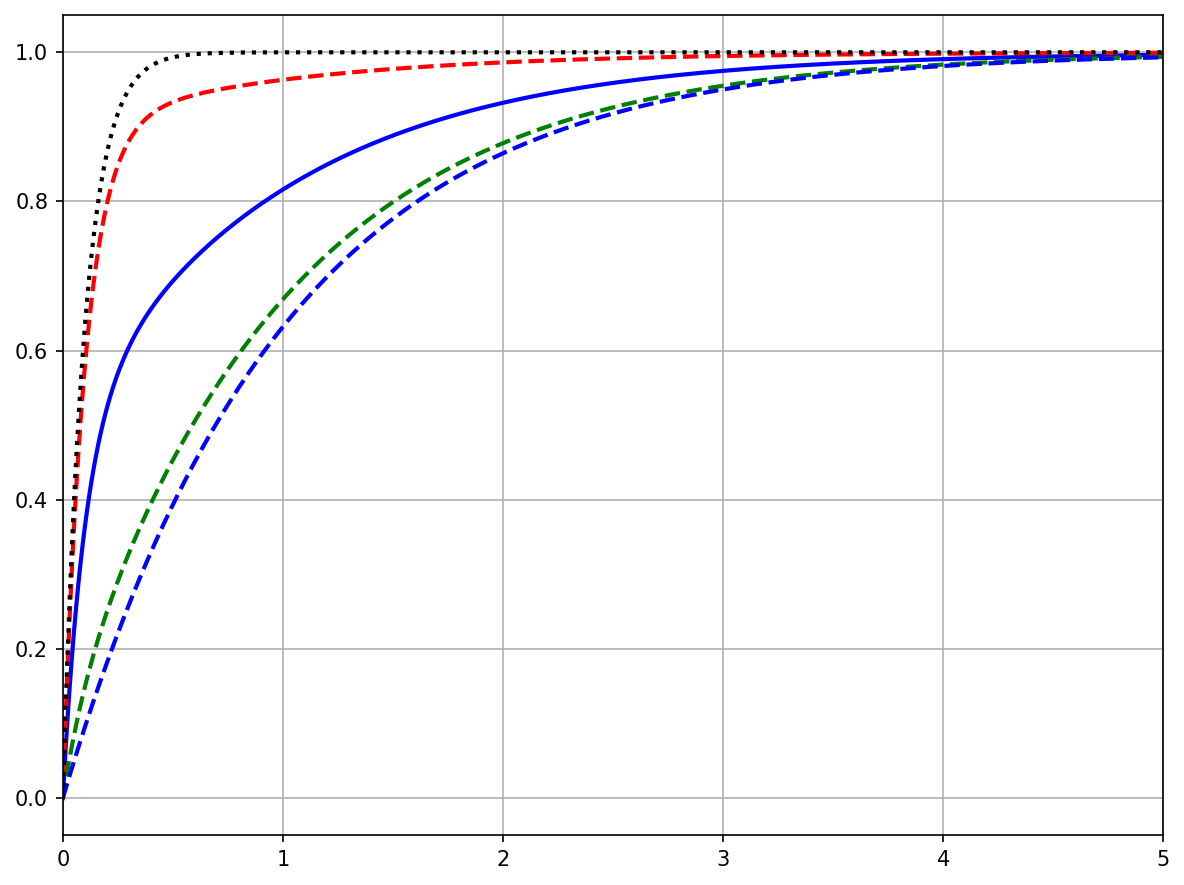

In [83]:
s = tf('s')
# slow
Pslow = 1/(s/1+1)
Pfast = 1/(s/10+1)

weight = 10

P11 = 1/2*Pslow + 1/2*Pfast
P12 = 1/weight*Pslow + (weight-1)/weight*Pfast
P21 = (weight-1)/weight*Pslow + 1/weight*Pfast
P22 = 1/2*Pslow + 1/2*Pfast

t = linspace(0,5,1000)
y11,t = step(P11,t)
y12,t = step(P12,t)
y21,t = step(P21,t)
y22,t = step(P22,t)
yslow,t = step(Pslow,t)
yfast,t = step(Pfast,t)

fig, ax = plt.subplots(1,figsize=(8, 6),dpi=150,sharex = True)
plt.plot(t,y11,'b',label='P11')
plt.plot(t,y12,'r--',label='P12')
plt.plot(t,y21,'g--',label='P21')
plt.plot(t,yslow,'b--',label='Slow')
plt.plot(t,yfast,'k:',label='Fast')
plt.show()

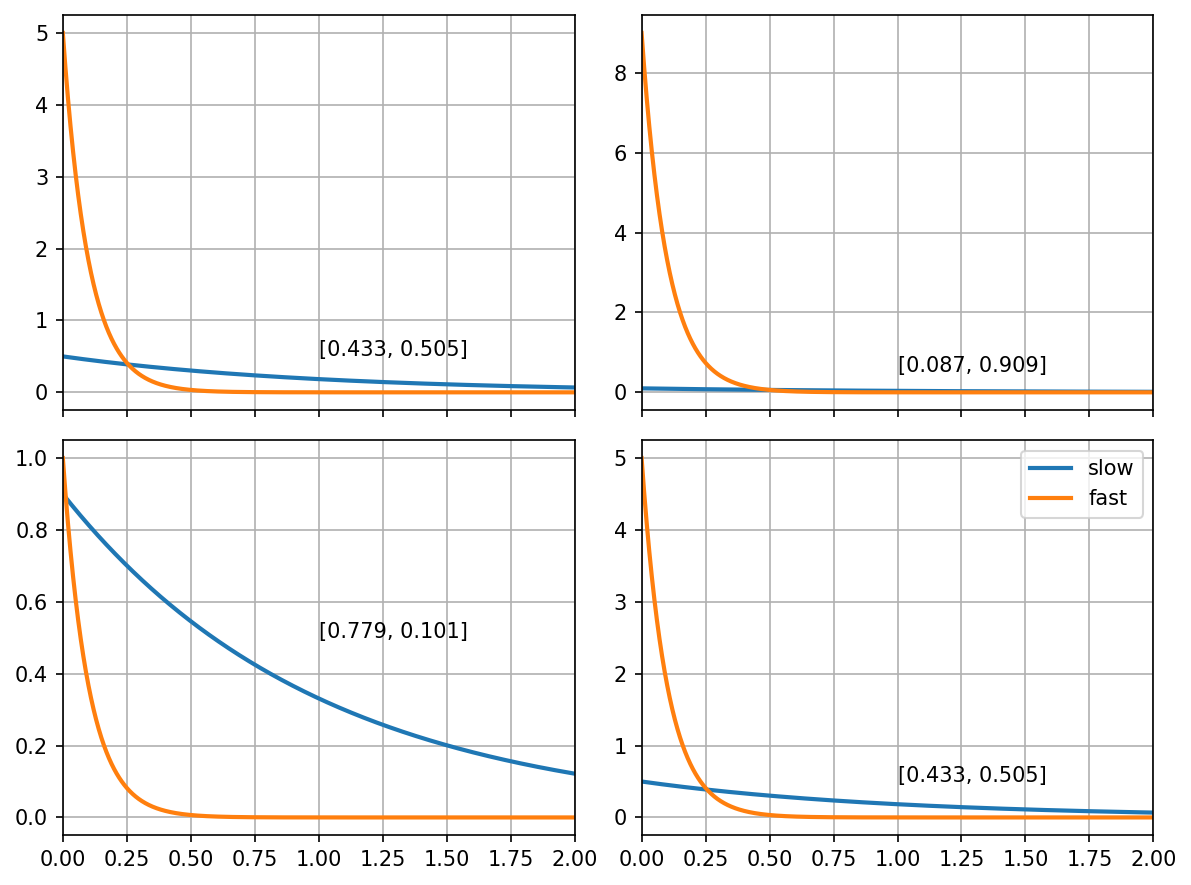

In [84]:
s = tf('s')
# slow
Pslow = 1/(s/1+1)
Pfast = 1/(s/10+1)

weight = 10
w1 = [1/2, 1/weight, (weight-1)/weight, 1/2]
w2 = [1/2, (weight-1)/weight, 1/weight, 1/2]
tt = np.linspace(0,2,1000)

fig, ax = plt.subplots(2,2,figsize=(8, 6),dpi=150,sharex = True)
for ii in range(2):
    for jj in range(2):
        PPslow = w1[2*ii+jj]*Pslow
        PPfast = w2[2*ii+jj]*Pfast
        tt,y_imp_slow = control.impulse_response(PPslow,T=tt)
        tt,y_imp_fast = control.impulse_response(PPfast,T=tt)
        y_imp_slow_integrated = np.round(np.cumsum(y_imp_slow)[-1] * (tt[1] - tt[0]),3)
        y_imp_fast_integrated = np.round(np.cumsum(y_imp_fast)[-1] * (tt[1] - tt[0]),3)
        ax[ii][jj].plot(tt, y_imp_slow)
        ax[ii][jj].plot(tt, y_imp_fast)
        ax[ii][jj].text(1,0.5,[y_imp_slow_integrated,y_imp_fast_integrated])
plt.legend(['slow', 'fast'])
plt.show()

In [85]:
P11_red = balred(P11,DCmatch=True,order=2)
P11_red

TransferFunction(array([   5.500,   10.000]), array([   1.000,   11.000,   10.000]))

In [86]:
P11

TransferFunction(array([   5.500,   10.000]), array([ 1, 11, 10]))

In [87]:
h = tf([1, 11, 36, 26],[1, 14.6, 74.96, 153.7, 99.65])
h

TransferFunction(array([ 1, 11, 36, 26]), array([   1.000,   14.600,   74.960,  153.700,   99.650]))

In [88]:
hbal = near_zero(balred(h,DCmatch=True,order = 1),Tol=1e-4)
hbal

TransferFunction(array([  -0.018,    1.215]), array([   1.000,    4.655]))

In [89]:
hbal_nm = near_zero(balred(h,DCmatch=False,order = 1),Tol=1e-4)
hbal_nm

TransferFunction(array([   1.004]), array([   1.000,    3.601]))

In [90]:
print([hbal.dcgain()/h.dcgain(), hbal_nm.dcgain()/h.dcgain()])

[0.9999999999999991, 1.0684393783434005]


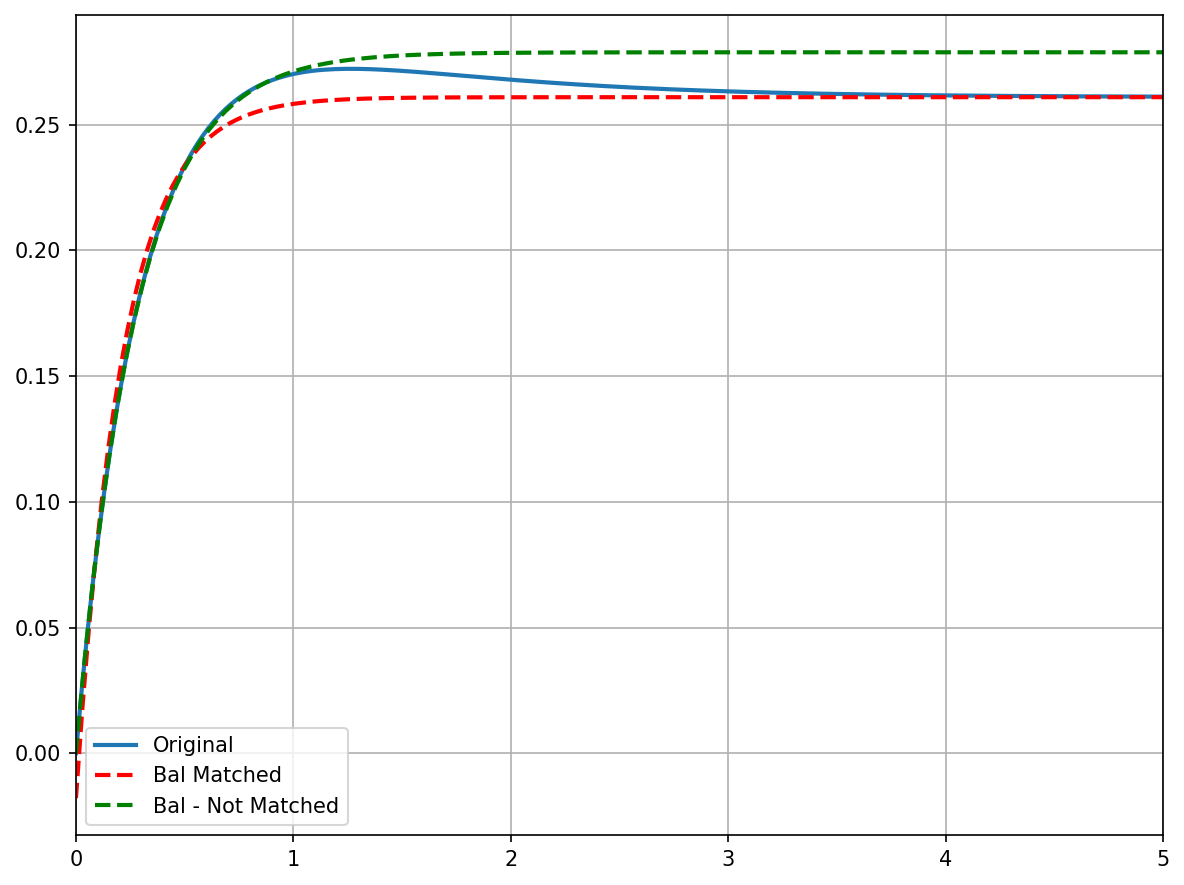

In [91]:
y,ty = step(h,5)
ybal,tbal = step(hbal,5)
ybal_nm,tbal_nm = step(hbal_nm,5)

fig, ax = plt.subplots(1,figsize=(8, 6),dpi=150,sharex = True)
plt.plot(ty,y,label='Original')
plt.plot(tbal,ybal,'r--',label='Bal Matched')
plt.plot(tbal_nm,ybal_nm,'g--',label='Bal - Not Matched')
plt.legend()
plt.show()

In [92]:
from sympy import symbols, inverse_laplace_transform, integrate, oo, simplify

# Define the Laplace variable and the transfer function with complex poles
s = symbols('s')
p, q, t, z = symbols('p q t z', positive=True)
omega = symbols('omega', positive=True)
PP = {}
PP['real'] = 1 / (s/p + 1)
PP['dreal'] = 1 / (s/p + 1)**2
PP['treal'] = 1 / (s/p + 1)/(s/q+1)
PP['zreal'] = (s/z+1) / (s/p + 1)/(s/q + 1)
PP['CC'] = (p**2+omega**2) / ((s + p)**2 + omega**2)

for P in PP.values():
    print(P)
    # Compute the inverse Laplace transform (impulse response)
    impulse_response = inverse_laplace_transform(P, s, t)

    # Integrate the impulse response from 0 to infinity
    #integrated_response = simplify(integrate(impulse_response, (t, 0, oo)))
    integrated_square_response = simplify(integrate(impulse_response**2, (t, 0, oo)))

    print(f"Impulse response: {impulse_response}")
    #print(f"Integrated response from 0 to infinity: {integrated_response}")
    print(f"Integrated square response from 0 to infinity: {integrated_square_response}")
    print('\n')

1/(1 + s/p)
Impulse response: p*exp(-p*t)
Integrated square response from 0 to infinity: p/2


(1 + s/p)**(-2)
Impulse response: p**2*t*exp(-p*t)
Integrated square response from 0 to infinity: p/4


1/((1 + s/p)*(1 + s/q))
Impulse response: p*q*exp(-t*(p*q - q**2)/(p - q))/(p - q) - p*q*exp(-t*(p**2 - p*q)/(p - q))/(p - q)
Integrated square response from 0 to infinity: p*q/(2*(p + q))


(s/z + 1)/((1 + s/p)*(1 + s/q))
Impulse response: (-p*q**2 + p*q*z)*exp(-t*(p*q*z - q**2*z)/(p*z - q*z))/(p*z - q*z) + (p**2*q - p*q*z)*exp(-t*(p**2*z - p*q*z)/(p*z - q*z))/(p*z - q*z)
Integrated square response from 0 to infinity: p*q*(p*q + z**2)/(2*z**2*(p + q))


(omega**2 + p**2)/(omega**2 + (p + s)**2)
Impulse response: (omega**2 + p**2)*exp(-p*t)*sin(omega*t)/omega
Integrated square response from 0 to infinity: (omega**2 + p**2)/(4*p)


